In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

# Iterative Soft Thresholding Algorithm (ISTA)

In [2]:
def softshrink(x, lambda_):
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)

In [3]:
def ISTA(y, A, L, eps = 1e-4, max_iter = 3000):

    x = np.random.randn(A.shape[1])

    loss = np.linalg.norm(y - A @ x)**2 + L * np.linalg.norm(x, ord = 1)
    losses = [loss]
    iters = 0

    B = A.T @ y
    C = A.T @ A

    mu = np.real(1 /np.max(np.linalg.eigvals(C)))
    
    while loss > eps and iters < max_iter:

        x_hat = x - mu*(C @ x - B) 
        x = softshrink(x_hat, L * mu)

        # Decreasing step size
        #mu *= 0.99

        # Loss tracking
        loss = np.linalg.norm(y - A @ x)**2 + L * np.linalg.norm(x, ord = 1)
        losses.append(loss)

        iters += 1
        
    return x, losses

In [4]:
S = np.zeros(200)
S[np.random.choice(200, 3)] = np.random.normal(scale=0.5, size = 3)

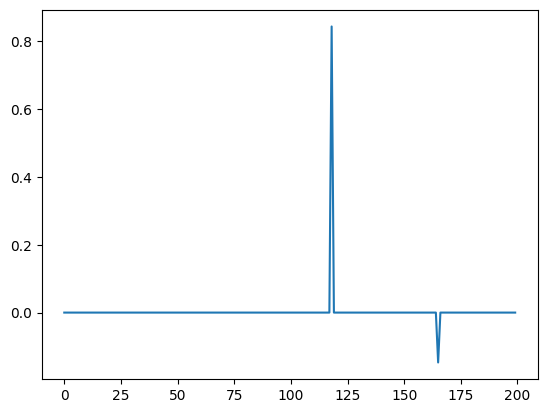

In [5]:
plt.plot(S)

In [6]:
A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

In [7]:
y = A @ S

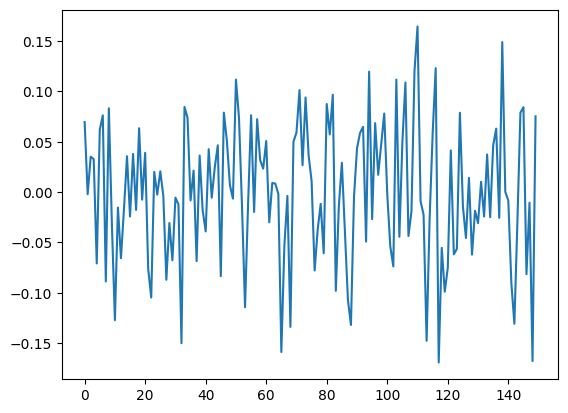

In [8]:
plt.plot(y)

In [9]:
x, losses = ISTA(y, A, 1e-1)

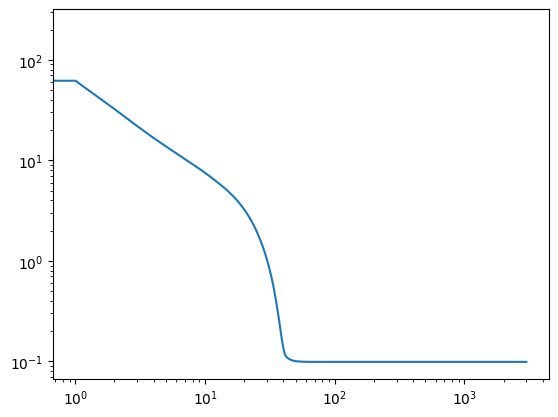

In [10]:
plt.loglog(losses)

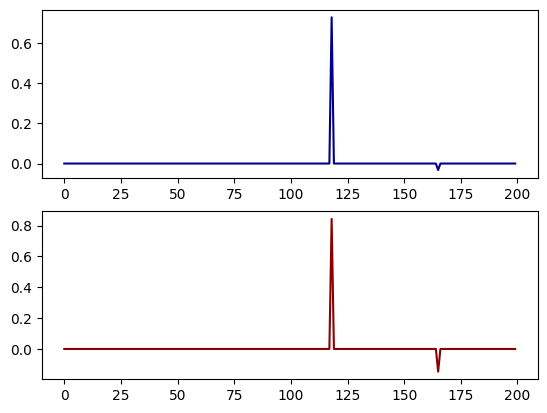

In [11]:
fig, axs = plt.subplots(2)

axs[0].plot(x, color='darkblue')
axs[1].plot(S, color='darkred')

plt.show()

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [12]:
class SyntheticSignals():
    def __init__(self, A, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 256):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)

        self.A = A          # Matrix for the linear observation

        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)


    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [13]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
s_ = 4

# Measurement matrix
A_ = torch.randn(150,200)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 200).set_loader()

In [92]:
class LISTA_LAYER(nn.Module):
    def __init__(self, A):
        super().__init__()

        # Measurement matrix 
        self.A = A
        self.N = self.A.shape[0]
        self.M = self.A.shape[1]

        # Initialization of the learnable parameters

        self.W1 = nn.Linear(self.N, self.M, bias=False)
        self.W2 = nn.Linear(self.M, self.M, bias=False)
        self.beta = nn.Parameter(torch.ones(1, 1, 1)*0.1, requires_grad=True)

        # Apply Xavier uniform initialization
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, x):       
        return self._shrink(self.W1(y) + self.W2(x), self.beta[0,:,:])

In [93]:
class LISTA(nn.Module):
    def __init__(self, A, K = 5):
        super(LISTA, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.LISTA_layers = nn.ModuleList([LISTA_LAYER(A) for _ in range(self.K)])

    def _shrink(self, x, beta):
            return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y):     
        x = torch.randn(y.shape[0], A.shape[1])

        for i in range(1, self.K):
            x = self.LISTA_layers[i].forward(y,x)
            
        return x

In [101]:
class LISTA(nn.Module):
    def __init__(self, A, rho = 1, K = 5):
        super(LISTA, self).__init__()

        # Linear layers
        self.W1 = nn.Linear(A.shape[0], A.shape[1], bias=False)  
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)  
        
        '''
        self.W1.weight.data = A.t()
        self.W2.weight.data = A.t() @ A
        '''

        # Number of layers <-> iterations
        self.K = K

        # Other parameters
        self.beta = nn.Parameter(torch.ones(self.K + 1, 1, 1)*0.01, 
                                 requires_grad=True)
        
        self.mu = nn.Parameter(torch.ones(self.K + 1, 1, 1), 
                                 requires_grad=True)
        
        self.rho = rho

    def _shrink(self, x, beta):
            return beta * F.softshrink(x / beta, lambd=self.rho)
    
    def forward(self, y):     
        x = self._shrink(self.mu[0,:,:]*self.W1(y), self.beta[0, :, :])

        for i in range(1, self.K + 1):
            x = self._shrink(x - self.mu[i,:,:]*(self.W2(x) + self.W1(y)),
                                 self.beta[i, :, :])
            
        return x

In [98]:
def train(model, train_loader, valid_loader, num_epochs=50):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )
    
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main loop
    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        for _, (b_x, b_s) in enumerate(train_loader):
            s_hat  = model.forward(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (b_x, b_s) in enumerate(valid_loader):
            s_hat  = model.forward(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

In [95]:
model = LISTA(A_)

In [99]:
list(model.parameters())

[Parameter containing:
 tensor([[[0.1000]]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0051, -0.0557,  0.0326,  ..., -0.0647, -0.0260,  0.1163],
         [-0.0432,  0.0627,  0.0542,  ...,  0.0184,  0.0785,  0.0375],
         [-0.0907, -0.0120, -0.1101,  ...,  0.0062, -0.0452, -0.0429],
         ...,
         [ 0.0687, -0.0518, -0.0672,  ..., -0.0163,  0.0331,  0.1139],
         [-0.1058, -0.0991, -0.0328,  ..., -0.0239, -0.0225, -0.0626],
         [ 0.0411,  0.0533,  0.1299,  ..., -0.0397, -0.0865, -0.0501]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1150,  0.0474, -0.0244,  ...,  0.0873,  0.0829, -0.0987],
         [ 0.0298, -0.0776, -0.0494,  ...,  0.0715, -0.0860, -0.0049],
         [-0.0641,  0.0725, -0.0864,  ..., -0.1057, -0.0665, -0.0079],
         ...,
         [-0.0719, -0.0613, -0.0787,  ..., -0.0180, -0.1002, -0.0279],
         [-0.0093, -0.0272,  0.0944,  ..., -0.0001,  0.0912, -0.1223],
         [-0.0362, -0.0801,  0.0892,  ...,  0.069

In [100]:
train(model, train_set, test_set)

Epoch 0, Train loss 1.04588104, Validation loss 0.91716057
Epoch 10, Train loss 1.04588105, Validation loss 0.91716049
Epoch 20, Train loss 1.04588105, Validation loss 0.91716049
Epoch 30, Train loss 1.04588107, Validation loss 0.91716049
Epoch 40, Train loss 1.04588107, Validation loss 0.91716049


array([0.91716057, 0.91716049, 0.91716049, 0.91716057, 0.91716057,
       0.91716049, 0.91716049, 0.91716057, 0.91716064, 0.91716049,
       0.91716049, 0.91716057, 0.91716049, 0.91716049, 0.91716057,
       0.91716064, 0.91716057, 0.91716057, 0.91716049, 0.91716049,
       0.91716049, 0.91716057, 0.91716057, 0.91716049, 0.91716049,
       0.91716057, 0.91716057, 0.91716049, 0.91716049, 0.91716057,
       0.91716049, 0.91716049, 0.91716049, 0.91716049, 0.91716049,
       0.91716049, 0.91716057, 0.91716049, 0.91716057, 0.91716049,
       0.91716049, 0.91716049, 0.91716057, 0.91716057, 0.91716049,
       0.91716049, 0.91716049, 0.91716049, 0.91716049, 0.91716057])